In [1]:
import sys
#sys.path.insert(0, '../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from pyDOE import lhs


np.random.seed(1234)
tf.set_random_seed(1234)

## Formulation

- Pressure Equation
$$\nabla\cdot[K(x)\cdot\frac{k_{rw}}{\mu_w}(\gamma S_o^n+S_w^n)\nabla P]=-(Q_o+Q_w)$$
- Saturation Equation
$$\phi\frac{\partial S_w}{\partial t} - \nabla\cdot[K(x)\cdot\frac{k_w}{\mu_w} S_w^n\nabla P] = Q_w$$

where

two-phase: $S_w+S_o=1$

relative permeability: $K_{r\sigma} = K_{\sigma}S_{\sigma}^n$,  $\sigma = o,w$

ratio of rel perm $K_{ro} = \alpha K_{rw}$

ratio of viscosity $\mu_o = \beta \mu_w$

ratio $\gamma = \frac{\alpha}{\beta}$

net source term $Q_\sigma = q_\sigma/\rho_\sigma$


Absorb $k_w/\mu_w$ term into $K(x)$ and we have

$$\nabla\cdot[K(x)(\gamma (1-S_w)^n+S_w^n)\nabla P]=-(Q_o+Q_w)$$

and 

$$\phi\frac{\partial S_w}{\partial t} - \nabla\cdot[K(x)S_w^n\nabla P] = Q_w$$


For simple 1D case, set

Boundary condition (rate)
- left: production
$Q_o+Q_w = -1$ at $x=-1$, otherwise $0$

- right: water injection production
$Q_w = 1$ at $x=1$, otherwise $0$

Boundary condition (close boundary)
$v_x = 0$ at $x=\pm1$


Initial condition 
- saturation (all oil)
$S_w = constant$ for all $-1\le x \le 1$

In 1D case, set

$$v_x = - K\partial_x P$$

then we have


$$\partial_x((\gamma (1-S_w)^n+S_w^n)v_x)=Q_o+Q_w$$

and

$$\phi\partial_t S_w + \partial_x(S_w^nv_x) = Q_w$$

Known rates: $Q_{prod}$ and $Q_{inj}$

$Q_w = Q_{inj} + Q_{prod}\times F_w$, $F_w = \frac{u_w}{u_w+u_i}=\frac{s_w^n}{\gamma s_(1-s_w)^n+s_w^n}$
$Q_o = Q_{prod}\times (1-F_w)$

$Q_o+Q_w = Q_{inj}+Q_{prod}$

In [2]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X_initial, U_initial, XT_boundary, U_boundary, XT_f, layers, lb, ub, gamma, phi, K, relpermn):
        #XT_initial, U_initial: where to enforce initial condition. X_initial is a 1D array (location), U_initial is 2D array
        #XT_boundary, U_boundary: where to enforece boundary condition. X_boundary is a 2D array (location and time), U_boundary is 2D array
        #XT_f: where to enforce physics equations

        #u is a 1 by 2 vector storing velocity and saturation
        
        self.lb = lb
        self.ub = ub
    
        self.gamma, self.phi, self.K, self.relpermn = gamma, phi, K, relpermn
        
        self.x_i = X_initial.reshape((X_initial.size,1))
        self.t_i = np.zeros((X_initial.size,1))
        self.u_i = U_initial
        
        self.x_b = XT_boundary[:,0:1]
        self.t_b = XT_boundary[:,1:2]
        self.u_b = U_boundary        
        
        self.x_f = XT_f[:,0:1]
        self.t_f = XT_f[:,1:2]
        
        self.layers = layers
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_i_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_i_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_i_tf = tf.placeholder(tf.float32, shape=[None, 2])

        self.x_b_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_b_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_b_tf = tf.placeholder(tf.float32, shape=[None, 2])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.u_i_pred = self.net_u(self.x_i_tf, self.t_i_tf)
        self.u_b_pred = self.net_u(self.x_b_tf, self.t_b_tf) 
        
        self.fp_pred, self.fs_pred = self.net_f(self.x_f_tf,self.t_f_tf)
        
        #self.loss_i = tf.reduce_mean(tf.square(self.u_i_pred[:,0:1] - self.u_i_tf[:,0:1])) + \
        #              tf.reduce_mean(tf.square(self.u_i_pred[:,1:2] - self.u_i_tf[:,1:2])) 
        #self.loss_i = tf.reduce_mean(tf.square(tf.sigmoid(self.u_i_pred[:,1:2]) - self.u_i_tf[:,1:2])) 
        self.loss_i = tf.reduce_mean(tf.square(self.u_i_pred[:,1:2] - self.u_i_tf[:,1:2])) #enforce initial saturation
        
        self.loss_b = tf.reduce_mean(tf.square(self.u_b_pred[:,0:1] - self.u_b_tf[:,0:1])) #only enforece velocity
        self.loss_f = tf.reduce_mean(tf.square(self.fp_pred)) + tf.reduce_mean(tf.square(self.fs_pred))
        
        self.loss = self.loss_i + self.loss_b + self.loss_f
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 100,
                                                                           'maxls': 100,
                                                                           'ftol' : 10.0 * np.finfo(float).eps})
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, XT, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(XT - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            #if l<num_layers-6:
            #    H = tf.nn.leaky_relu(tf.add(tf.matmul(H, W), b))
            #else:
            H = tf.tanh(tf.add(tf.matmul(H, W), b))

            
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        
        return Y
            
    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return tf.concat((u[:,0:1],tf.sigmoid(u[:,1:2])),1)
    
    def net_f(self, x, t):
        u = self.net_u(x,t)
        vx = u[:,0:1]
        sw = u[:,1:2]
        sw_t = tf.gradients(sw,t)[0]
        
        #Q=-1 if x=-0.75 or -6 at 0.75, otherwise 0
        Q_prod = - 1*tf.exp(-900.0*tf.pow(x-0.75,2)) \
        - 6*tf.exp(-900.0*tf.pow(x+0.75,2))

        #Qw = 7 if x=-0.05, otherwise 0
        Q_inj = 7*tf.exp(-900.0*tf.pow(x,2))

        if self.relpermn==1:
            if self.gamma==1:
                mobility = 1.0
            else:
                mobility = self.gamma*(1-sw) + sw
        else:
            mobility = self.gamma*tf.pow(1-sw,self.relpermn)+tf.pow(sw,self.relpermn)

        Fw = tf.pow(sw, self.relpermn)/mobility
        Q_o = Q_prod*(1-Fw)
        Q_w = Q_inj + Q_prod*Fw
    
        p_eqn_LHS = tf.gradients(mobility*vx,x)[0]
        p_eqn_RHS = Q_inj + Q_prod
        
        if self.relpermn==1:
            s_eqn_LHS = self.phi*sw_t + tf.gradients(sw*vx,x)[0]
        else:
            s_eqn_LHS = self.phi*sw_t + tf.gradients(tf.pow(sw,self.relpermn)*vx,x)[0]
            
        s_eqn_RHS = Q_w
        
        f_p = p_eqn_LHS - p_eqn_RHS
        f_s = s_eqn_LHS - s_eqn_RHS
        
        return f_p, f_s
    
    def callback(self, loss, loss_i, loss_b, loss_f):
        self.iter += 1
        if (self.iter % 100 == 0):
            print('Iter: %05d, Loss: %e, Loss_i: %e, Loss_b: %e, Loss_f: %e' % (self.iter, loss, loss_i, loss_b, loss_f))
        
    def train(self):

        tf_dict = {self.x_i_tf: self.x_i, self.t_i_tf: self.t_i, self.u_i_tf: self.u_i,
                   self.x_b_tf: self.x_b, self.t_b_tf: self.t_b, self.u_b_tf: self.u_b,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        self.iter = 0                                                                                                            
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss, self.loss_i, self.loss_b, self.loss_f], 
                                loss_callback = self.callback)        
                                    
          
    def predict(self, XT):
        u = self.sess.run(self.u_i_pred, {self.x_i_tf: XT[:,0:1],self.t_i_tf: XT[:,1:2]})
        v = u[:,0:1]
        s = u[:,1:2]
        fp = self.sess.run(self.fp_pred, {self.x_f_tf: XT[:,0:1],self.t_f_tf: XT[:,1:2]})
        fs = self.sess.run(self.fs_pred, {self.x_f_tf: XT[:,0:1],self.t_f_tf: XT[:,1:2]})
        return v, s, fp, fs

## Training Neural Net with Initial & Boundary Condition and Physics Laws

In [3]:
N_i = 32 #number of points to enforce on initial condition
N_b = 32 #number of points to enforce on boundary condition
N_f = 256 #number of points to enforce on physics

#layers = [2, 20, 20, 20, 20, 1]
layers = [2, 20, 20, 20, 20, 20, 20, 2]
#layers = [2, 32, 32, 32, 32, 32, 2]
#layers = [2, 16, 32, 32, 32, 32, 64, 64, 32, 32, 32, 32, 8, 4, 2]

gamma, phi, K, relpermn = 0.2, 0.2, 1, 2

t = np.linspace(0,1,N_b)
x = np.linspace(-1,1,N_i)

X, T = np.meshgrid(x,t)

x_star = np.linspace(-1,1,257)
t_star = np.linspace(0,1,101)
X_star, T_star = np.meshgrid(x_star, t_star)
XT_star = np.c_[X_star.flatten(),T_star.flatten()]

#### Initial Conditions

In [4]:
X_initial = x.copy()
vx_i = np.zeros((X_initial.size,1))
s_i = 0.2*np.ones((X_initial.size,1))
U_initial = np.c_[vx_i,s_i]

#### Boundary conditions

In [5]:
t_b = np.r_[t,t]
x_b = np.r_[np.ones((t.size,1)),-1*np.ones((t.size,1))]
vx_b = np.zeros((x_b.size,1))
s_b = np.zeros((x_b.size,1)) # this won't be used

XT_boundary = np.c_[x_b,t_b]
U_boundary = np.c_[vx_b,s_b]

#### collocation point

In [6]:
lb = np.array([x.min(),t.min()])
ub = np.array([x.max(),t.max()])

XT_f = lb + (ub-lb)*lhs(2, N_f)

x_nearWell = np.r_[lhs(1,8)*0.2-0.85,lhs(1,8)*0.2+0.65,lhs(1,8)*0.2-0.1]
t_forNearWell = np.linspace(0,1,17)
X_nearWell,T_forNearWell = np.meshgrid(x_nearWell,t_forNearWell)

XT_f = np.r_[XT_boundary,XT_f, np.c_[X_initial,0*X_initial], np.c_[X_nearWell.flatten(),T_forNearWell.flatten()]]

In [7]:
X_nearWell.size

408

In [8]:
#XT_f = np.array([XT_f[i] for i in range(XT_f.shape[0]) if ((XT_f[i,1]<0.5) or (np.abs(XT_f[i,0]-0.75)<0.05) or ((np.abs(XT_f[i,0]+0.75)<0.05)))])


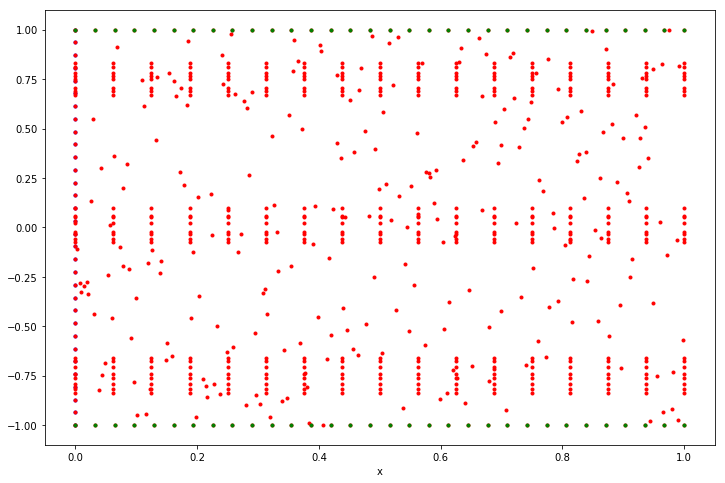

In [9]:
plt.figure(figsize=(12,8))
plt.plot(X_initial*0,X_initial,'b.')
plt.plot(XT_f[:,1],XT_f[:,0],'r.')
plt.plot(XT_boundary[:,1],XT_boundary[:,0],'g.')
plt.xlabel('t')
plt.xlabel('x')

In [10]:
model = PhysicsInformedNN(X_initial, U_initial, XT_boundary, U_boundary, XT_f, layers, lb, ub, gamma, phi, K, relpermn)

C:\Users\xiang.zhai\AppData\Local\Continuum\Miniconda2\envs\ML\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
start_time = time.time()                
model.train()
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

Iter: 00100, Loss: 1.387275e-01, Loss_i: 3.618571e-02, Loss_b: 2.293540e-04, Loss_f: 1.023125e-01
Iter: 00200, Loss: 8.711383e-02, Loss_i: 2.475243e-02, Loss_b: 7.367621e-04, Loss_f: 6.162465e-02
Iter: 00300, Loss: 7.517212e-02, Loss_i: 2.543806e-02, Loss_b: 2.275381e-05, Loss_f: 4.971130e-02
Iter: 00400, Loss: 4.581366e-02, Loss_i: 1.870939e-02, Loss_b: 4.181109e-05, Loss_f: 2.706246e-02
Iter: 00500, Loss: 2.416825e-02, Loss_i: 9.988646e-03, Loss_b: 2.521263e-05, Loss_f: 1.415439e-02
Iter: 00600, Loss: 1.532082e-02, Loss_i: 3.857234e-03, Loss_b: 2.816811e-04, Loss_f: 1.118190e-02
Iter: 00700, Loss: 9.701985e-03, Loss_i: 2.345894e-03, Loss_b: 1.101841e-04, Loss_f: 7.245907e-03
Iter: 00800, Loss: 6.763181e-03, Loss_i: 1.796312e-03, Loss_b: 8.894218e-05, Loss_f: 4.877927e-03
Iter: 00900, Loss: 4.958146e-03, Loss_i: 1.160030e-03, Loss_b: 8.960620e-06, Loss_f: 3.789156e-03
Iter: 01000, Loss: 3.908152e-03, Loss_i: 8.919895e-04, Loss_b: 6.633772e-06, Loss_f: 3.009529e-03
Iter: 01100, Loss: 3

Iter: 08500, Loss: 4.197952e-05, Loss_i: 1.128343e-05, Loss_b: 1.738757e-07, Loss_f: 3.052221e-05
Iter: 08600, Loss: 4.140472e-05, Loss_i: 1.109297e-05, Loss_b: 1.619764e-07, Loss_f: 3.014978e-05
Iter: 08700, Loss: 4.053004e-05, Loss_i: 1.120438e-05, Loss_b: 1.284496e-07, Loss_f: 2.919721e-05
Iter: 08800, Loss: 3.965323e-05, Loss_i: 1.092948e-05, Loss_b: 1.227107e-07, Loss_f: 2.860104e-05
Iter: 08900, Loss: 3.886929e-05, Loss_i: 1.100876e-05, Loss_b: 1.109342e-07, Loss_f: 2.774960e-05
Iter: 09000, Loss: 3.810399e-05, Loss_i: 1.117364e-05, Loss_b: 1.411082e-07, Loss_f: 2.678924e-05
Iter: 09100, Loss: 3.705794e-05, Loss_i: 1.104030e-05, Loss_b: 1.901910e-07, Loss_f: 2.582745e-05
Iter: 09200, Loss: 3.603976e-05, Loss_i: 1.098667e-05, Loss_b: 2.040536e-07, Loss_f: 2.484904e-05
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000036
  Number of iterations: 8881
  Number of functions evaluations: 9271
Tr

In [12]:
v_pred, s_pred, fp_pred, fs_pred = model.predict(XT_star)

In [13]:
V_pred = v_pred.reshape(X_star.shape)
S_pred = s_pred.reshape(X_star.shape)
Fp_pred = fp_pred.reshape(X_star.shape)
Fs_pred = fs_pred.reshape(X_star.shape)

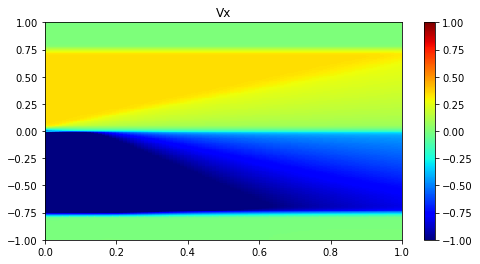

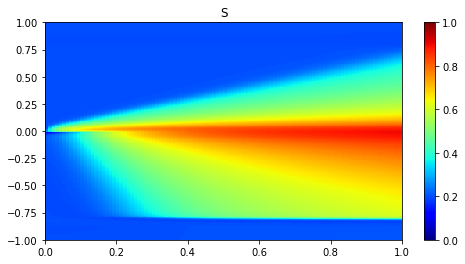

In [14]:
plt.figure(figsize=(8,4))
plt.pcolor(T_star, X_star, V_pred,cmap='jet', vmin = -1, vmax = 1)
plt.colorbar()
plt.title('Vx')


plt.figure(figsize=(8,4))
plt.pcolor(T_star, X_star, S_pred,cmap='jet', vmin=0.,vmax=1)
plt.colorbar()
plt.title('S')

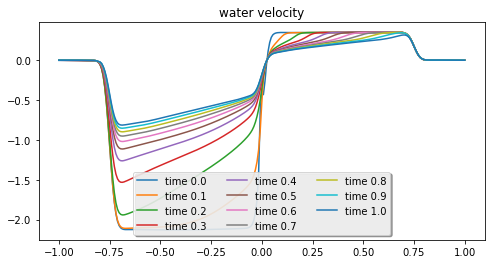

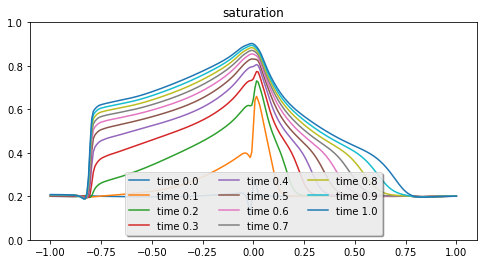

In [15]:
plt.figure(figsize=(8,4))
for tmp_i in range(0,t_star.shape[0],10):
    tmp_t = t_star[tmp_i]
    tmp_v_pred = V_pred[tmp_i]
    
    plt.plot(x_star,tmp_v_pred,label='time %2.1f' % (tmp_t))
    #plt.plot(Exact[tmp_i,:],':')
plt.legend(loc='lower center',ncol=3, fancybox=True, shadow=True)
plt.title('water velocity')

plt.figure(figsize=(8,4))
for tmp_i in range(0,t_star.shape[0],10):
    tmp_t = t_star[tmp_i]
    tmp_s_pred = S_pred[tmp_i]
    
    plt.plot(x_star,tmp_s_pred,label='time %2.1f' % (tmp_t))
plt.ylim([0,1])
plt.legend(loc='lower center',ncol=3, fancybox=True, shadow=True)
plt.title('saturation')
